✅ SHAP is available
✅ All imports successful!
📅 Analysis date: 2025-12-04 02:02:47
📋 ML Configuration loaded!
   Target: no_show
   Primary metric: roc_auc
   Tuning strategy: random
   CV folds: 5

📊 Data loaded: 110,527 rows × 52 columns

🎯 Target distribution:
no_show
0    88208
1    22319
Name: count, dtype: int64

   No-show rate: 20.2%

📊 Data Split:
   Training: 88,421 samples
   Test: 22,106 samples
   Features: 30

🔄 After Preprocessing:
   Training shape: (88421, 44)
   Test shape: (22106, 44)
   Total features (after encoding): 44

📋 Sample Feature Names (after encoding):
    1. numeric__age
    2. numeric__lead_days
    3. numeric__patient_total_appointments
    4. numeric__patient_previous_noshows
    5. numeric__patient_historical_noshow_rate
    6. numeric__neighborhood_noshow_rate
    7. numeric__neighborhood_avg_age
    8. numeric__schedule_hour
    9. categorical__gender_M
   10. categorical__age_group_Child
   11. categorical__age_group_Middle Age
   12. categorical_

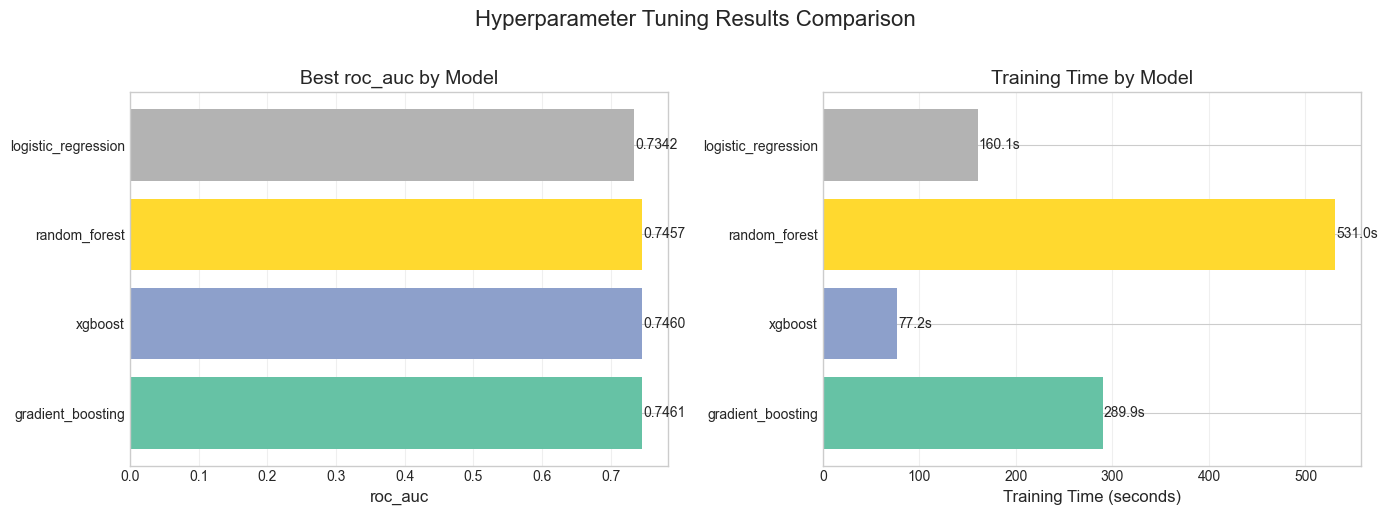

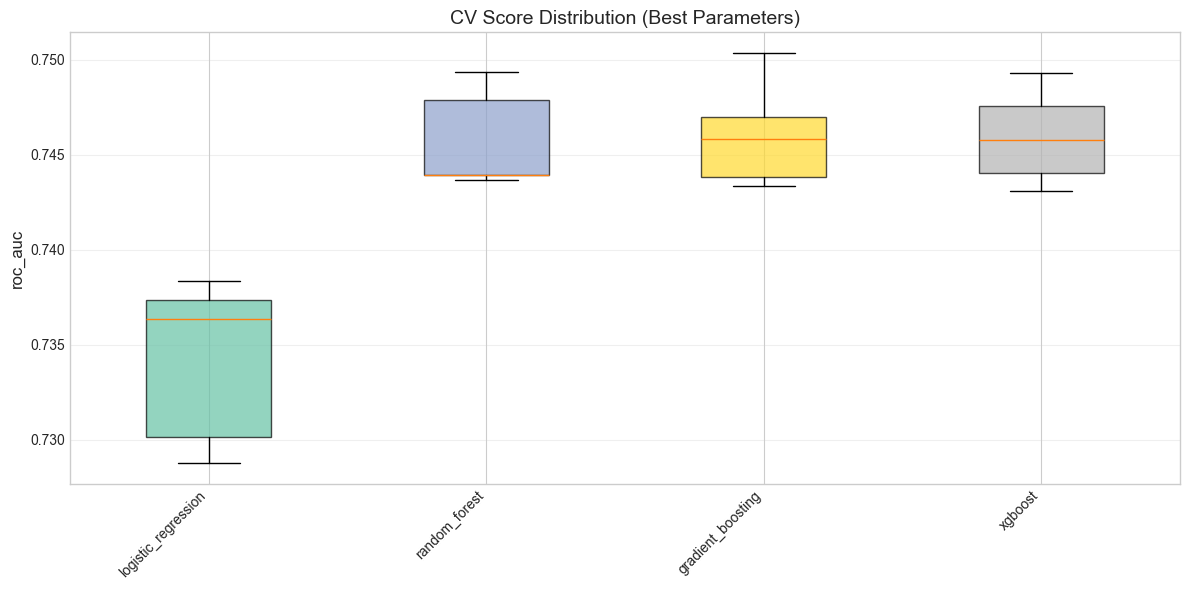

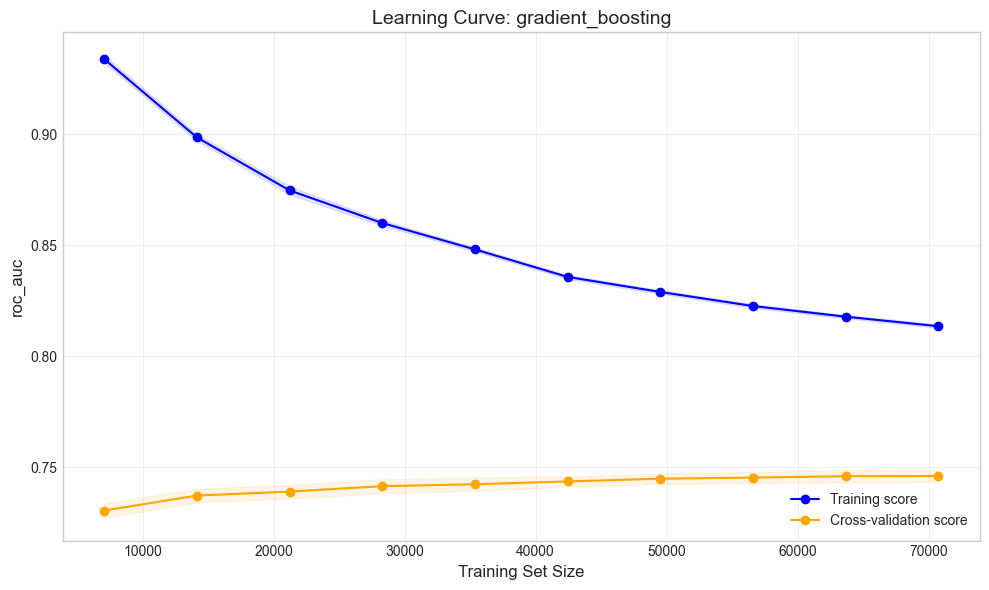


📊 Test Set Performance (Tuned Models):
              Model  Accuracy  Precision  Recall  F1 Score  ROC-AUC  Avg Precision  Brier Score
            xgboost    0.8025     0.6592  0.0459    0.0859   0.7433         0.4115       0.1417
  gradient_boosting    0.8029     0.6801  0.0453    0.0849   0.7419         0.4138       0.1418
      random_forest    0.6562     0.3341  0.7074    0.4539   0.7399         0.4111       0.1931
logistic_regression    0.8010     0.5724  0.0567    0.1031   0.7320         0.3903       0.1433

📈 Improvement from Tuning:
   Baseline ROC-AUC: 0.7370
   Tuned ROC-AUC:    0.7419
   Improvement:      +0.48%


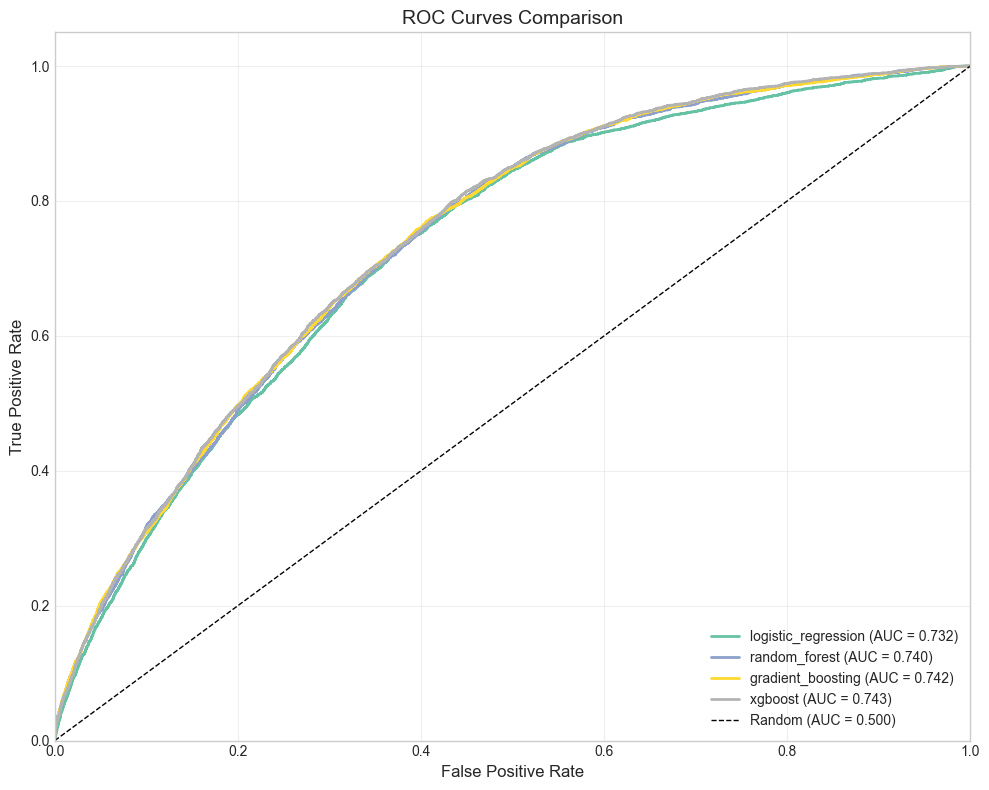

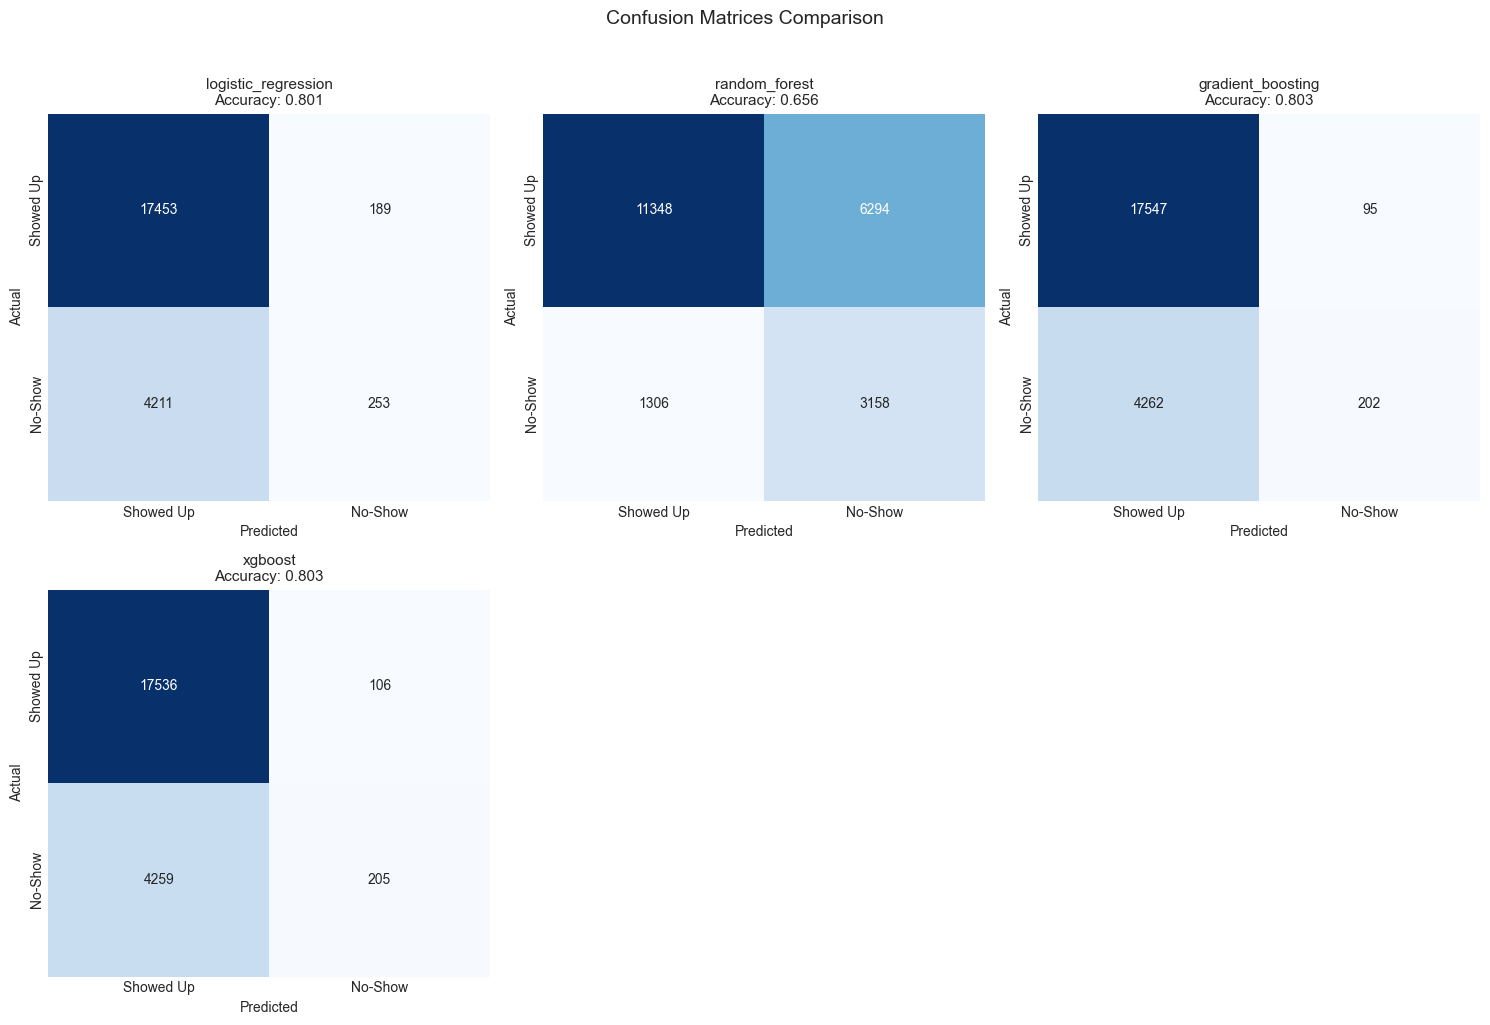

✅ Interpreter fitted for gradient_boosting


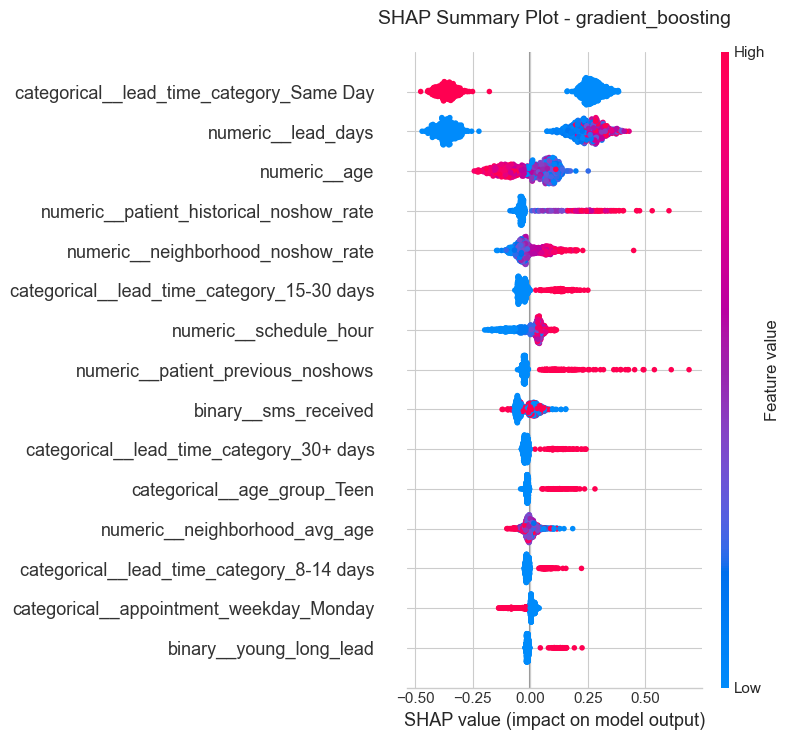

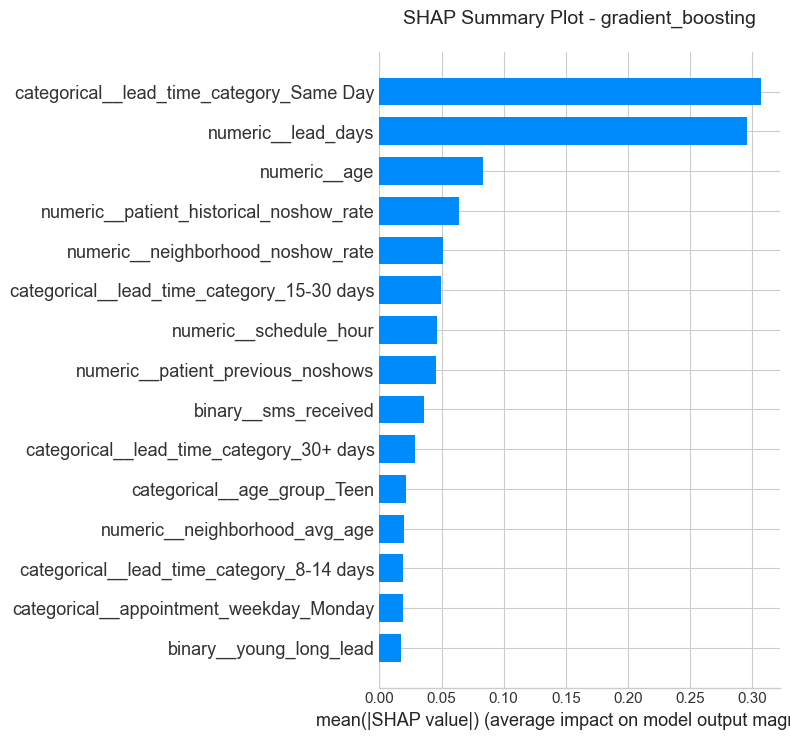

📋 Explaining prediction for sample 0
   Predicted probability: 53.1%
   Actual outcome: No-Show


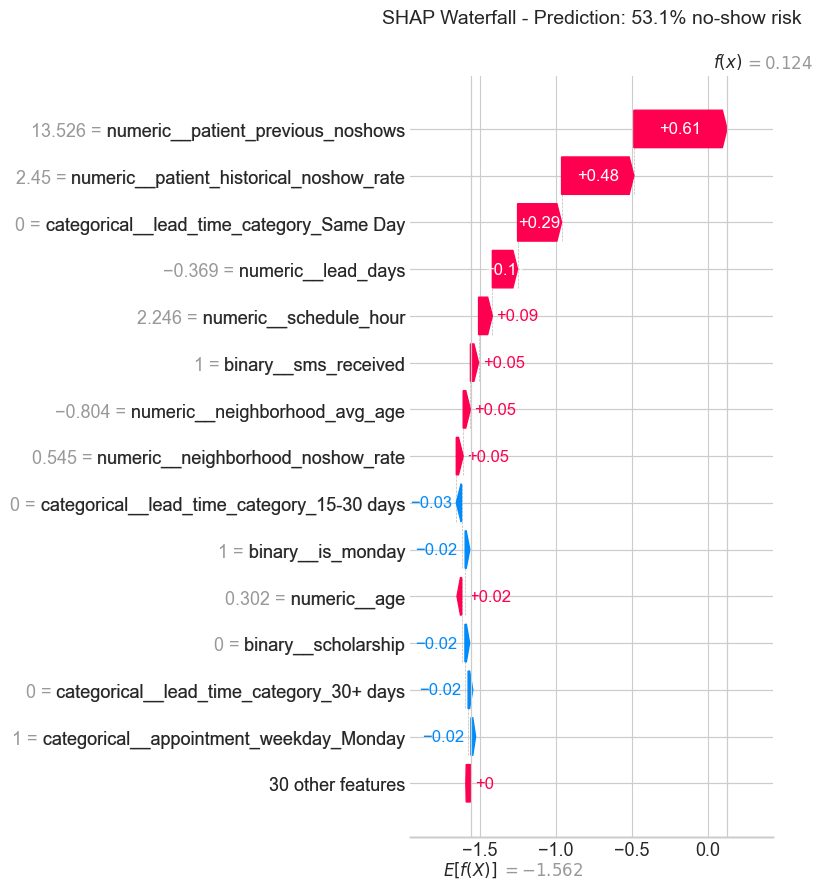

📊 Top 4 features for dependence plots:
                                 feature  importance
categorical__lead_time_category_Same Day      0.3070
                      numeric__lead_days      0.2960
                            numeric__age      0.0834
 numeric__patient_historical_noshow_rate      0.0638

📈 Dependence plot for: categorical__lead_time_category_Same Day


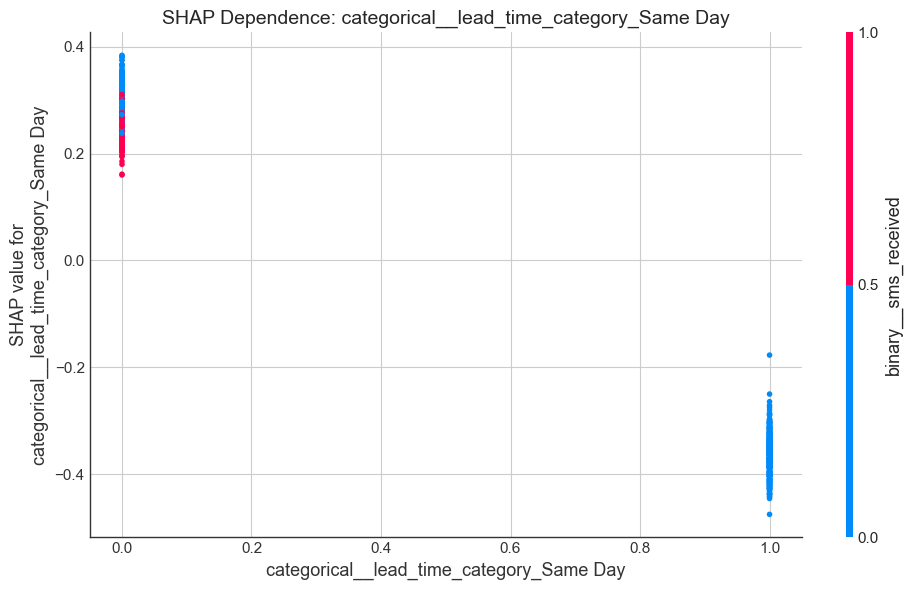


📈 Dependence plot for: numeric__lead_days


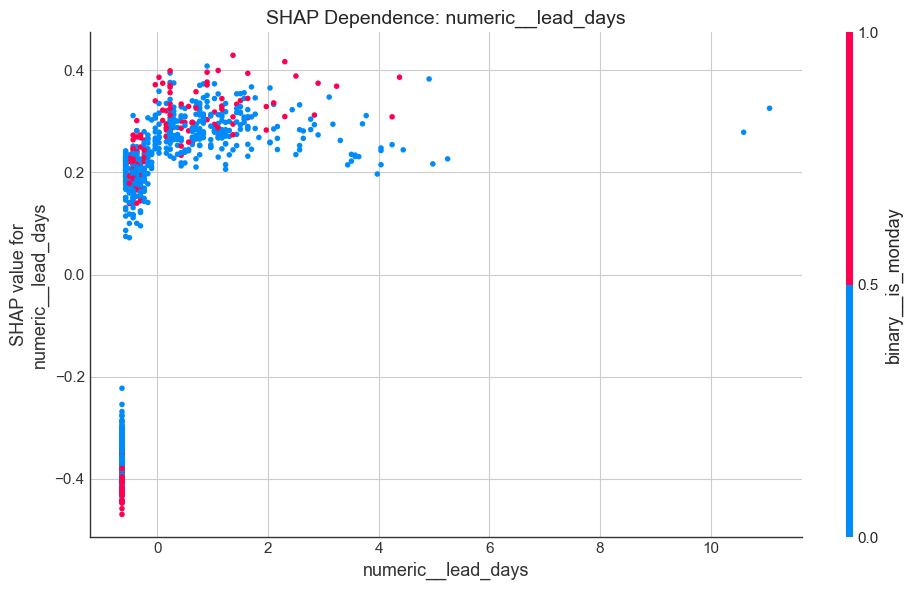


PREDICTION EXPLANATION - Sample 0
Prediction: 53.1% no-show probability
Risk Tier: HIGH

🔺 Top factors INCREASING no-show risk:
   • numeric__patient_previous_noshows: +0.6125
   • numeric__patient_historical_noshow_rate: +0.4751
   • categorical__lead_time_category_Same Day: +0.2893

🔻 Top factors DECREASING no-show risk:
   • categorical__lead_time_category_15-30 days: -0.0345
   • binary__is_monday: -0.0239
   • binary__scholarship: -0.0214

PREDICTION EXPLANATION - Sample 10
Prediction: 61.1% no-show probability
Risk Tier: HIGH

🔺 Top factors INCREASING no-show risk:
   • numeric__patient_previous_noshows: +0.6898
   • numeric__patient_historical_noshow_rate: +0.5298
   • categorical__lead_time_category_Same Day: +0.2634

🔻 Top factors DECREASING no-show risk:
   • numeric__schedule_hour: -0.1158
   • categorical__lead_time_category_15-30 days: -0.0183
   • categorical__lead_time_category_8-14 days: -0.0164

PREDICTION EXPLANATION - Sample 50
Prediction: 8.1% no-show probability
R

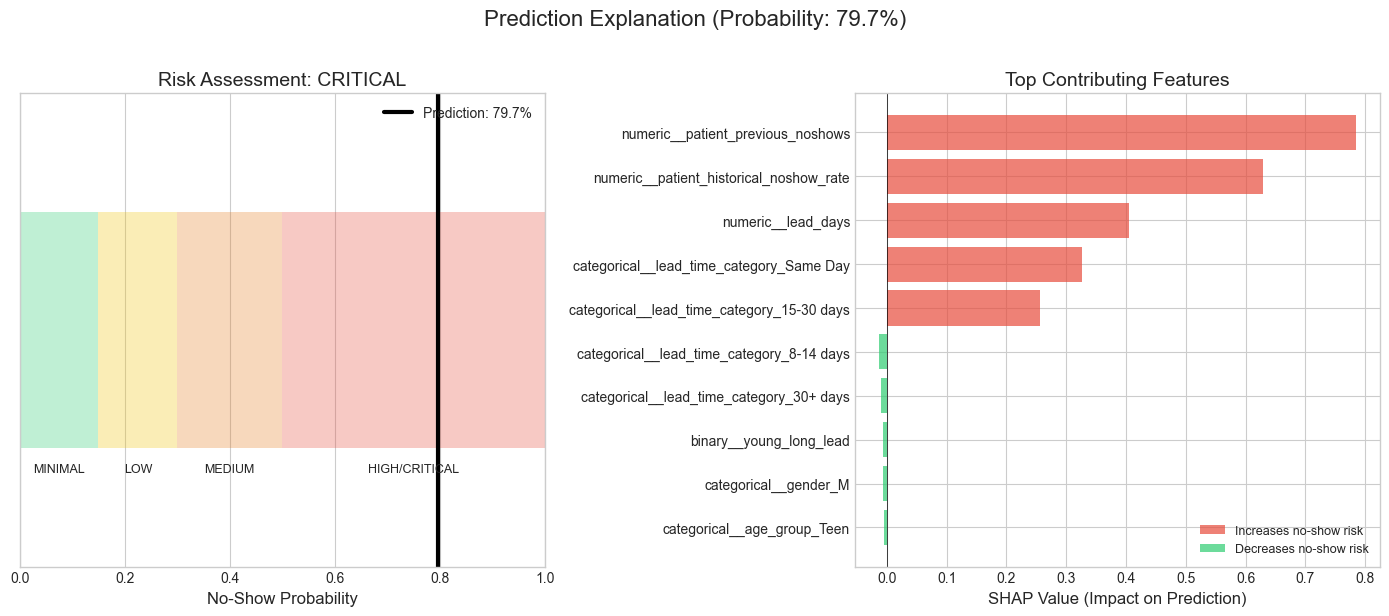

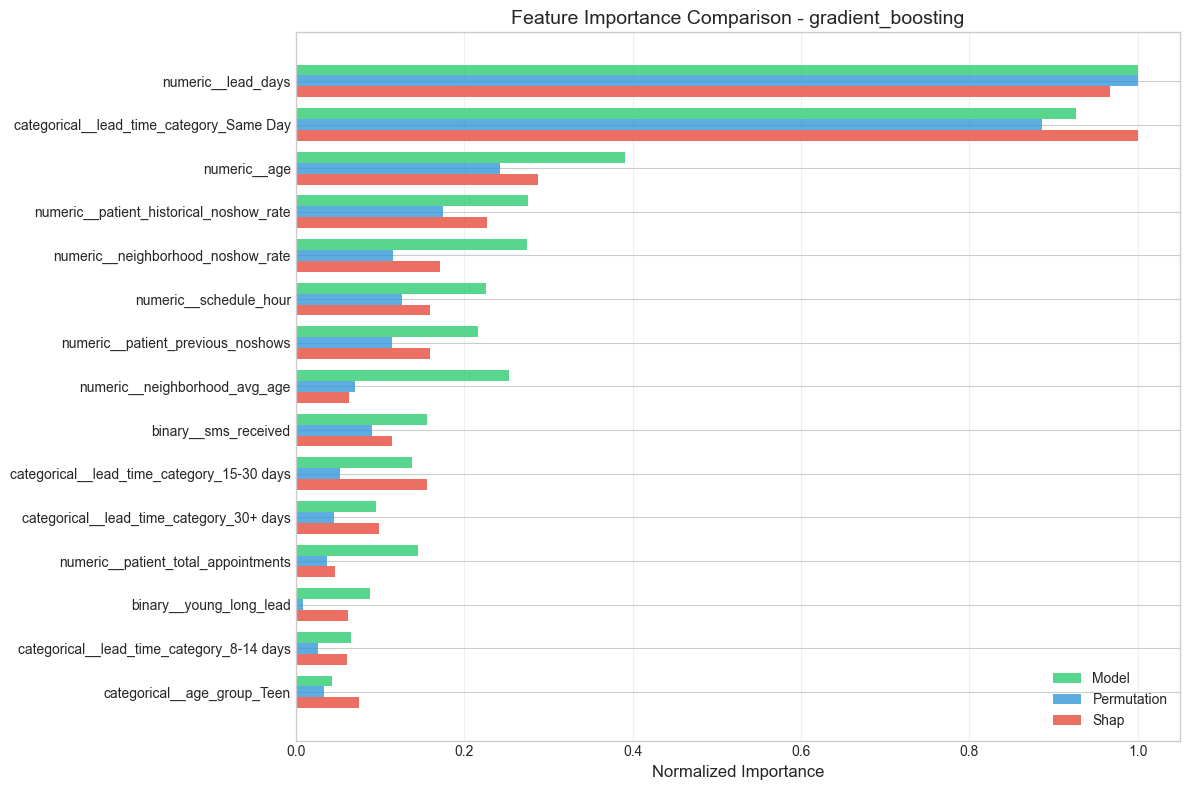

📊 Feature Importance Summary

🌲 Model-based Importance (top 10):
                                 feature  importance
                      numeric__lead_days      0.1971
categorical__lead_time_category_Same Day      0.1827
                            numeric__age      0.0772
 numeric__patient_historical_noshow_rate      0.0543
       numeric__neighborhood_noshow_rate      0.0542
           numeric__neighborhood_avg_age      0.0499
                  numeric__schedule_hour      0.0447
       numeric__patient_previous_noshows      0.0426
                    binary__sms_received      0.0308
     numeric__patient_total_appointments      0.0287

📊 SHAP-based Importance (top 10):
                                   feature  importance
  categorical__lead_time_category_Same Day      0.3048
                        numeric__lead_days      0.2949
                              numeric__age      0.0878
   numeric__patient_historical_noshow_rate      0.0694
         numeric__neighborhood_noshow_rate

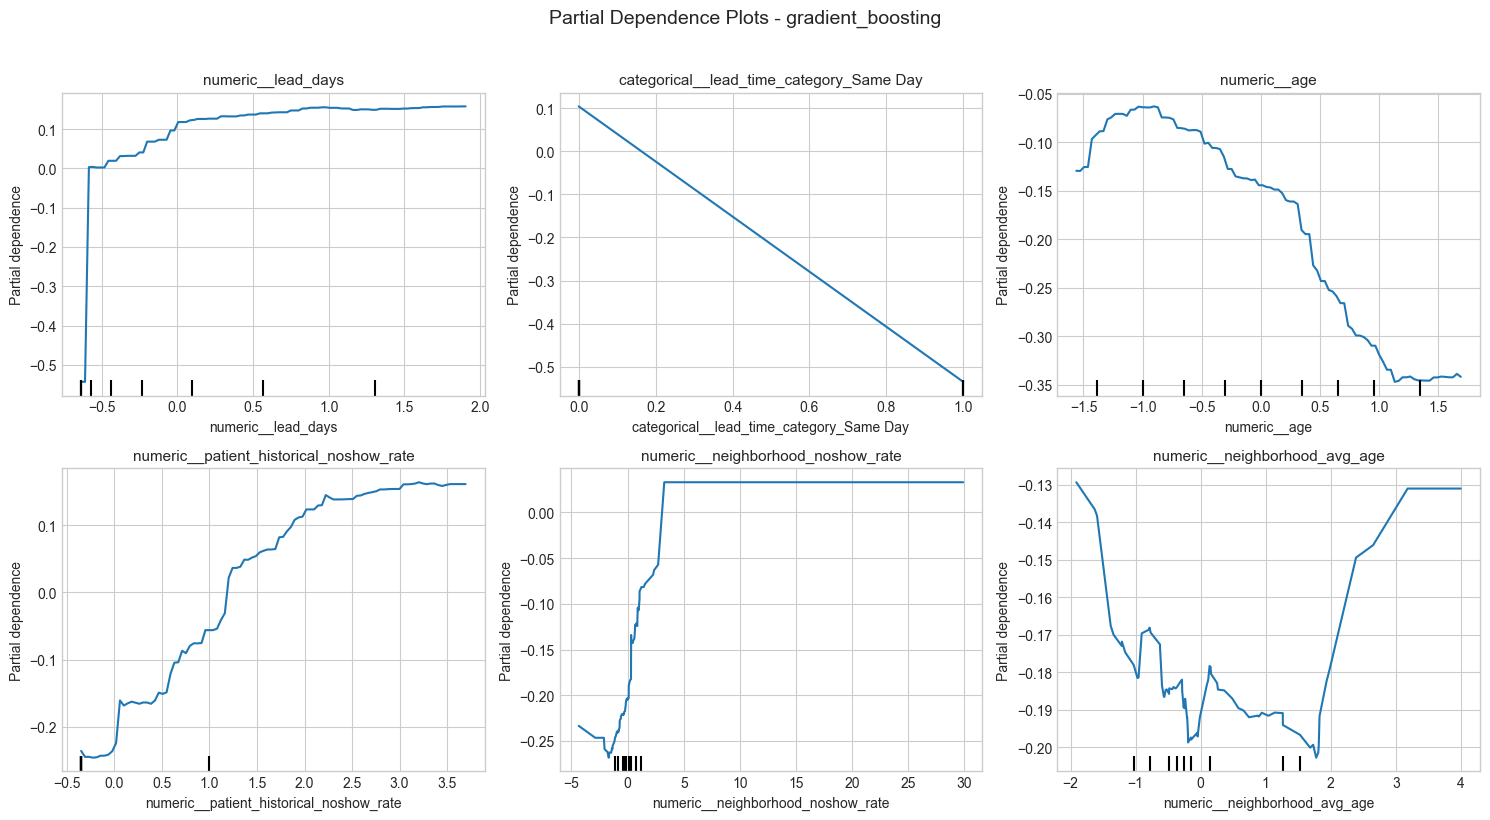

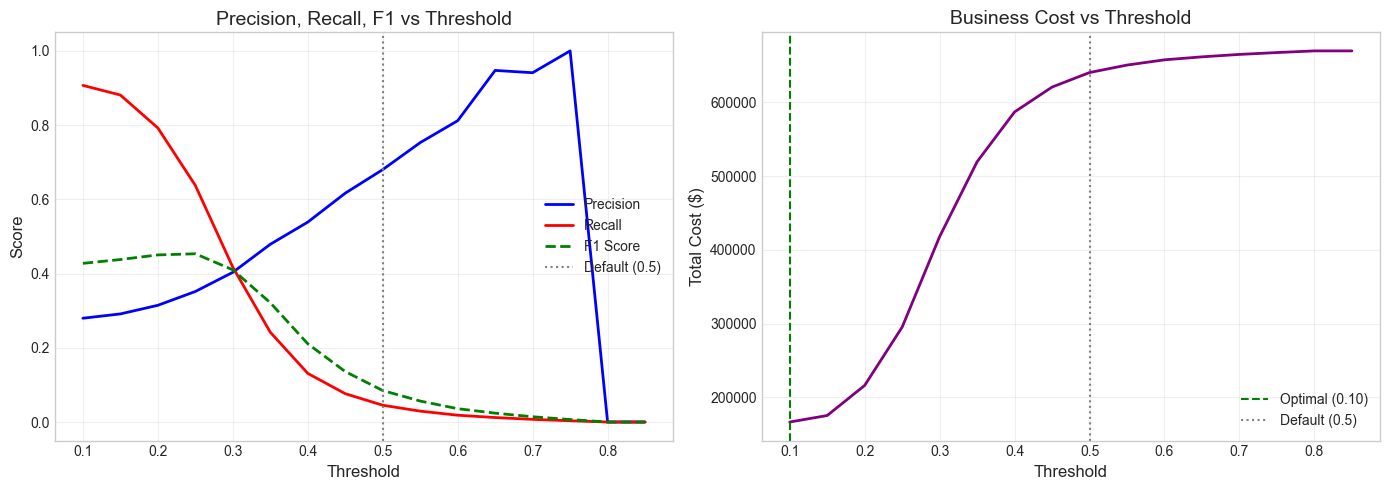


🎯 Optimal Threshold: 0.10
   At this threshold:
   - Precision: 0.280
   - Recall: 0.907
   - F1 Score: 0.428

📊 Threshold Comparison:

Threshold = 0.50:
   True Positives (correct no-show predictions): 202
   False Positives (unnecessary interventions): 95
   False Negatives (missed no-shows): 4262
   True Negatives (correct show-up predictions): 17547
   Precision: 0.680
   Recall: 0.045
   Estimated Cost: $640,250

Threshold = 0.10:
   True Positives (correct no-show predictions): 4049
   False Positives (unnecessary interventions): 10428
   False Negatives (missed no-shows): 415
   True Negatives (correct show-up predictions): 7214
   Precision: 0.280
   Recall: 0.907
   Estimated Cost: $166,530
📁 Saving results to: ..\outputs\experiments\week6_20251204_022259
   Saved: logistic_regression_tuned.joblib
   Saved: random_forest_tuned.joblib
   Saved: gradient_boosting_tuned.joblib
   Saved: xgboost_tuned.joblib
   Saved: preprocessor.joblib

📄 Interpretation Report (excerpt):
------

IndexError: index 0 is out of bounds for axis 0 with size 0

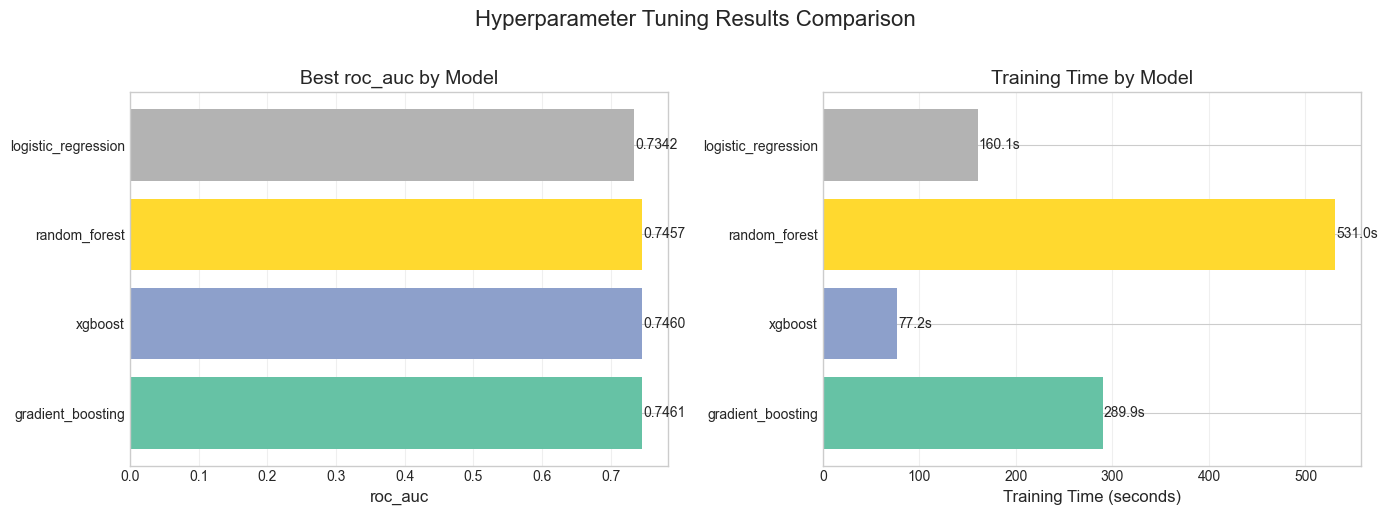

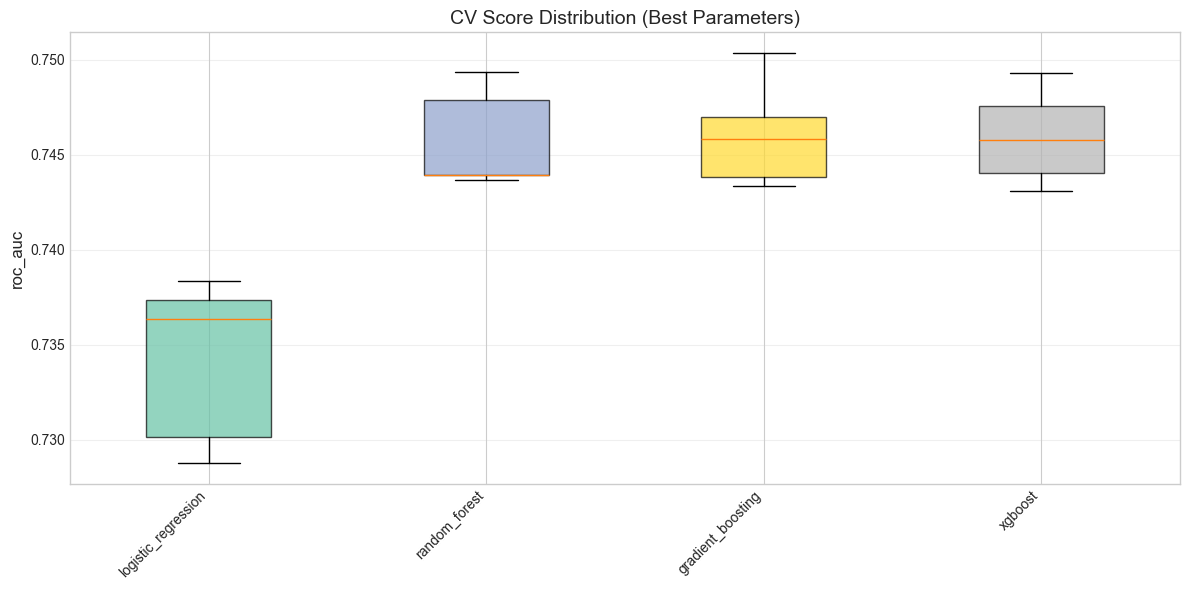

In [1]:
# %% [markdown]
"""
# Week 6: Model Tuning & Interpretability

## Learning Objectives
- Build reproducible sklearn pipelines
- Tune hyperparameters with GridSearchCV and RandomizedSearchCV
- Interpret models using SHAP values
- Understand feature importance from multiple perspectives
- Optimize decision thresholds for business objectives

## Prerequisites
- Completed Week 5 (baseline models trained)
- SHAP library installed (`pip install shap`)

## What We'll Cover
1. **sklearn Pipelines** - End-to-end reproducible workflows
2. **Hyperparameter Tuning** - Finding optimal model parameters
3. **SHAP Analysis** - Understanding model predictions
4. **Feature Importance** - Comparing importance methods
5. **Threshold Optimization** - Business-driven decision making
"""

# %% [markdown]
"""
## 1. Setup and Configuration
"""

# %%
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import json
from pathlib import Path
from datetime import datetime

# Add src to path
sys.path.insert(0, str(Path.cwd().parent))

# sklearn imports
from sklearn.model_selection import (
    train_test_split, cross_val_score, 
    GridSearchCV, RandomizedSearchCV,
    StratifiedKFold, learning_curve
)
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, roc_curve,
    precision_recall_curve
)

# Our ML modules
from src.ml.preprocessing import NoShowPreprocessor
from src.ml.train import ModelTrainer
from src.ml.evaluate import ModelEvaluator
from src.ml.pipeline import NoShowPipelineBuilder, PipelineManager
from src.ml.tuning import HyperparameterTuner
from src.ml.interpret import ModelInterpreter, create_interpretation_report

import yaml
import joblib

# SHAP (optional but recommended)
try:
    import shap
    SHAP_AVAILABLE = True
    print("✅ SHAP is available")
except ImportError:
    SHAP_AVAILABLE = False
    print("⚠️ SHAP not installed. Run: pip install shap")

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.4f}'.format)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ All imports successful!")
print(f"📅 Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# %%
# Load configurations
with open('../config/ml_config.yaml', 'r') as f:
    ml_config = yaml.safe_load(f)

print("📋 ML Configuration loaded!")
print(f"   Target: {ml_config['ml_project']['target_column']}")
print(f"   Primary metric: {ml_config['evaluation']['primary_metric']}")
print(f"   Tuning strategy: {ml_config['tuning']['strategy']}")
print(f"   CV folds: {ml_config['tuning']['cv_folds']}")

# %%
# Load processed data
data_path = '../data/processed/appointments_features.csv'
df = pd.read_csv(data_path)

print(f"\n📊 Data loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\n🎯 Target distribution:")
print(df['no_show'].value_counts())
print(f"\n   No-show rate: {df['no_show'].mean():.1%}")

# %% [markdown]
"""
## 2. Data Preparation with Preprocessing Pipeline

We'll use our `NoShowPreprocessor` class to create a reproducible
preprocessing pipeline that handles:
- Feature selection
- Missing value imputation
- Categorical encoding
- Numeric scaling
"""

# %%
# Initialize preprocessor
preprocessor = NoShowPreprocessor(ml_config)

# Prepare data (select features and split)
X_train, X_test, y_train, y_test = preprocessor.prepare_data(df)

print(f"\n📊 Data Split:")
print(f"   Training: {len(X_train):,} samples")
print(f"   Test: {len(X_test):,} samples")
print(f"   Features: {X_train.shape[1]}")

# %%
# Fit and transform training data
X_train_transformed = preprocessor.fit_transform(X_train, y_train)
X_test_transformed = preprocessor.transform(X_test)

print(f"\n🔄 After Preprocessing:")
print(f"   Training shape: {X_train_transformed.shape}")
print(f"   Test shape: {X_test_transformed.shape}")
print(f"   Total features (after encoding): {len(preprocessor.feature_names_)}")

# %%
# Show sample of feature names
print("\n📋 Sample Feature Names (after encoding):")
for i, name in enumerate(preprocessor.feature_names_[:20]):
    print(f"   {i+1:2d}. {name}")
if len(preprocessor.feature_names_) > 20:
    print(f"   ... and {len(preprocessor.feature_names_) - 20} more features")

# %% [markdown]
"""
## 3. Building sklearn Pipelines

sklearn Pipelines chain preprocessing and modeling steps together,
ensuring:
- No data leakage (preprocessing fit only on training data)
- Reproducibility (same transformations applied consistently)
- Easy deployment (single object to save/load)
"""

# %%
# Create pipelines for different models using our PipelineBuilder
pipeline_manager = PipelineManager(ml_config)

# Create pipelines for all models
pipelines = pipeline_manager.create_all_pipelines(X_train)

print("🔧 Created Pipelines:")
for name in pipelines.keys():
    print(f"   • {name}")

# %%
# Examine one pipeline structure
sample_pipeline = pipelines['random_forest']
print("\n📋 Random Forest Pipeline Structure:")
print("-" * 40)
for step_name, step in sample_pipeline.named_steps.items():
    print(f"Step: {step_name}")
    print(f"  Type: {type(step).__name__}")

# %% [markdown]
"""
## 4. Hyperparameter Tuning

We'll use RandomizedSearchCV to efficiently search the hyperparameter space.
This is more efficient than GridSearchCV when the search space is large.

### Why Tune Hyperparameters?
- Default parameters are rarely optimal
- Model performance can vary significantly with different parameters
- Prevents overfitting through proper regularization
"""

# %%
# Initialize the hyperparameter tuner
tuner = HyperparameterTuner(ml_config)

print("⚙️ Hyperparameter Tuner Configuration:")
print(f"   Strategy: {tuner.strategy}")
print(f"   Max iterations: {tuner.n_iter}")
print(f"   CV folds: {tuner.cv_folds}")
print(f"   Scoring metric: {tuner.scoring}")

# %%
# Show parameter grids
print("\n📋 Parameter Grids to Search:")
print("-" * 50)

for model_name, params in tuner.param_grids.items():
    print(f"\n{model_name}:")
    for param, values in params.items():
        if isinstance(values, list):
            print(f"   {param}: {values[:5]}{'...' if len(values) > 5 else ''}")
        else:
            print(f"   {param}: {values}")

# %% [markdown]
"""
### 4.1 Tune All Models

This will take some time depending on:
- Size of parameter grids
- Number of CV folds
- Training data size
"""

# %%
# Tune all models (this may take a few minutes)
print("🔄 Starting hyperparameter tuning...")
print("   This may take several minutes...\n")

# We'll tune 3 key models for time efficiency
# You can add more models as needed
models_to_tune = ['logistic_regression', 'random_forest', 'gradient_boosting']

# Add XGBoost if available
try:
    from xgboost import XGBClassifier
    models_to_tune.append('xgboost')
    print("   Including XGBoost in tuning\n")
except ImportError:
    print("   XGBoost not available, skipping\n")

# Run tuning
tuning_results = tuner.tune_all_models(
    X_train_transformed, 
    y_train,
    model_names=models_to_tune
)

# %%
# Display tuning comparison
comparison = tuner.get_comparison_table()
print("\n📊 Tuning Results Comparison:")
print("=" * 70)
print(comparison.to_string(index=False))

# %%
# Display best parameters for each model
params_table = tuner.get_best_params_table()
print("\n🎯 Best Parameters Found:")
print("=" * 70)
for _, row in params_table.iterrows():
    print(f"\n{row['Model']}:")
    for col in params_table.columns[1:]:
        if pd.notna(row[col]):
            print(f"   {col}: {row[col]}")

# %%
# Get the best overall model
best_model_name, best_model = tuner.get_best_model()
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Best {tuner.scoring}: {tuner.results[best_model_name].best_score:.4f}")

# %% [markdown]
"""
### 4.2 Visualize Tuning Results
"""

# %%
# Plot tuning comparison
output_dir = Path('../outputs/figures/ml/tuning')
output_dir.mkdir(parents=True, exist_ok=True)

fig = tuner.plot_comparison(save=True, output_dir=output_dir)
plt.show()

# %%
# Plot CV score distributions
fig = tuner.plot_cv_scores_distribution(save=True, output_dir=output_dir)
plt.show()

# %%
# Plot learning curve for best model
fig = tuner.plot_learning_curve(
    best_model_name, 
    X_train_transformed, 
    y_train,
    save=True, 
    output_dir=output_dir
)
plt.show()

# %% [markdown]
"""
### 4.3 Evaluate Tuned Model on Test Set
"""

# %%
# Evaluate best model on test set
evaluator = ModelEvaluator(ml_config)

# Evaluate tuned models
tuned_results = evaluator.evaluate_all(
    tuner.best_models, 
    X_test_transformed, 
    y_test
)

# %%
# Display test results
test_comparison = evaluator.get_comparison_table()
print("\n📊 Test Set Performance (Tuned Models):")
print("=" * 70)
print(test_comparison.to_string(index=False))

# %%
# Compare with baseline (Week 5) if available
baseline_model_path = Path('../models/baseline/random_forest.joblib')
if baseline_model_path.exists():
    baseline_model = joblib.load(baseline_model_path)
    baseline_pred = baseline_model.predict_proba(X_test_transformed)[:, 1]
    baseline_auc = roc_auc_score(y_test, baseline_pred)
    
    tuned_pred = best_model.predict_proba(X_test_transformed)[:, 1]
    tuned_auc = roc_auc_score(y_test, tuned_pred)
    
    print(f"\n📈 Improvement from Tuning:")
    print(f"   Baseline ROC-AUC: {baseline_auc:.4f}")
    print(f"   Tuned ROC-AUC:    {tuned_auc:.4f}")
    print(f"   Improvement:      {(tuned_auc - baseline_auc)*100:+.2f}%")
else:
    print("\n⚠️ Baseline model not found for comparison")

# %%
# Plot ROC curves for tuned models
fig = evaluator.plot_roc_curves(save=True, filename="roc_curves_tuned.png")
plt.show()

# %%
# Plot confusion matrices
fig = evaluator.plot_confusion_matrices(save=True, filename="confusion_matrices_tuned.png")
plt.show()

# %% [markdown]
"""
## 5. Model Interpretability with SHAP

SHAP (SHapley Additive exPlanations) helps us understand:
- **Global interpretability**: Which features are most important overall?
- **Local interpretability**: Why did the model make this specific prediction?

### Key Concepts:
- **SHAP value**: The contribution of each feature to a prediction
- **Base value**: The average model output (expected value)
- **Positive SHAP**: Feature pushes prediction toward no-show
- **Negative SHAP**: Feature pushes prediction toward showing up
"""

# %%
if SHAP_AVAILABLE:
    # Initialize interpreter with best model
    interpreter = ModelInterpreter(ml_config)
    
    # Fit interpreter with training data as background
    # Use a sample for efficiency
    background_samples = min(500, len(X_train_transformed))
    X_background = X_train_transformed[:background_samples]
    
    interpreter.fit(
        best_model,
        X_background,
        feature_names=preprocessor.feature_names_,
        model_name=best_model_name
    )
    
    print(f"✅ Interpreter fitted for {best_model_name}")
else:
    print("⚠️ SHAP not available. Skipping SHAP analysis.")
    interpreter = None

# %% [markdown]
"""
### 5.1 SHAP Summary Plots

The summary plot shows:
- Each point is a sample
- Y-axis: Features (sorted by importance)
- X-axis: SHAP value (impact on prediction)
- Color: Feature value (red=high, blue=low)
"""

# %%
if interpreter:
    # Compute SHAP values for test set (use sample for speed)
    shap_sample_size = min(1000, len(X_test_transformed))
    X_shap = X_test_transformed[:shap_sample_size]
    
    # SHAP beeswarm plot
    fig = interpreter.plot_shap_summary(X_shap, plot_type='dot', max_display=15)
    plt.show()

# %%
if interpreter:
    # SHAP bar plot (mean |SHAP| values)
    fig = interpreter.plot_shap_bar(X_shap, max_display=15)
    plt.show()

# %% [markdown]
"""
### 5.2 SHAP Waterfall Plot

The waterfall plot explains a single prediction:
- Shows how each feature contributes
- Starts from base value (average prediction)
- Each feature pushes the prediction up or down
"""

# %%
if interpreter:
    # Find a high-risk prediction to explain
    y_proba = best_model.predict_proba(X_test_transformed)[:, 1]
    high_risk_indices = np.where(y_proba > 0.5)[0]
    
    if len(high_risk_indices) > 0:
        # Pick a random high-risk case
        sample_idx = high_risk_indices[0]
        print(f"📋 Explaining prediction for sample {sample_idx}")
        print(f"   Predicted probability: {y_proba[sample_idx]:.1%}")
        print(f"   Actual outcome: {'No-Show' if y_test.iloc[sample_idx] == 1 else 'Showed Up'}")
        
        # Create waterfall plot
        fig = interpreter.plot_shap_waterfall(X_test_transformed, sample_idx=sample_idx)
        plt.show()
    else:
        print("No high-risk predictions found")

# %% [markdown]
"""
### 5.3 SHAP Dependence Plots

Dependence plots show how a feature's value affects predictions:
- X-axis: Feature value
- Y-axis: SHAP value
- Color: Interacting feature
"""

# %%
if interpreter:
    # Get top features
    shap_importance = interpreter.get_shap_importance()
    if shap_importance:
        top_features_df = shap_importance.to_dataframe().head(4)
        print("📊 Top 4 features for dependence plots:")
        print(top_features_df.to_string(index=False))
        
        # Create dependence plots for top features
        for i, row in top_features_df.head(2).iterrows():
            feature_name = row['feature']
            print(f"\n📈 Dependence plot for: {feature_name}")
            fig = interpreter.plot_shap_dependence(X_shap, feature_name)
            plt.show()

# %% [markdown]
"""
### 5.4 Individual Prediction Explanation

Let's explain specific predictions in human-readable format.
"""

# %%
if interpreter:
    # Explain a few predictions
    sample_indices = [0, 10, 50]  # Low, medium, high risk examples
    
    for idx in sample_indices:
        if idx < len(X_test_transformed):
            explanation = interpreter.explain_prediction(X_test_transformed[idx])
            
            print(f"\n{'='*60}")
            print(f"PREDICTION EXPLANATION - Sample {idx}")
            print(f"{'='*60}")
            print(f"Prediction: {explanation.probability:.1%} no-show probability")
            print(f"Risk Tier: {explanation.risk_tier}")
            
            print(f"\n🔺 Top factors INCREASING no-show risk:")
            for feat, val, impact in explanation.top_positive_features[:3]:
                print(f"   • {feat}: {impact:+.4f}")
            
            print(f"\n🔻 Top factors DECREASING no-show risk:")
            for feat, val, impact in explanation.top_negative_features[:3]:
                print(f"   • {feat}: {impact:+.4f}")

# %%
if interpreter:
    # Visual explanation for one prediction
    high_risk_idx = np.argmax(y_proba)
    explanation = interpreter.explain_prediction(X_test_transformed[high_risk_idx])
    
    fig = interpreter.plot_prediction_explanation(explanation)
    plt.show()

# %% [markdown]
"""
## 6. Feature Importance Comparison

Let's compare feature importance from different methods:
1. **Model-based** (e.g., tree feature_importances_)
2. **Permutation importance** (model-agnostic)
3. **SHAP values** (game-theoretic)
"""

# %%
if interpreter:
    # Generate comparison plot
    fig = interpreter.plot_feature_importance_comparison(
        X_test_transformed, 
        y_test,
        top_n=15
    )
    plt.show()

# %%
# Get detailed importance tables
if interpreter:
    print("📊 Feature Importance Summary")
    print("=" * 60)
    
    # Model-based importance
    model_imp = interpreter.get_model_feature_importance()
    if model_imp:
        print("\n🌲 Model-based Importance (top 10):")
        print(model_imp.to_dataframe().head(10).to_string(index=False))
    
    # SHAP importance
    shap_imp = interpreter.get_shap_importance()
    if shap_imp:
        print("\n📊 SHAP-based Importance (top 10):")
        print(shap_imp.to_dataframe().head(10).to_string(index=False))

# %% [markdown]
"""
## 7. Partial Dependence Plots (PDP)

PDPs show the marginal effect of features on predictions,
averaging out the effects of all other features.
"""

# %%
if interpreter:
    # Create partial dependence plots for top features
    fig = interpreter.plot_partial_dependence(X_test_transformed, n_cols=3)
    plt.show()

# %% [markdown]
"""
## 8. Threshold Optimization

The default classification threshold is 0.5, but this may not be optimal
for our business case. We want to balance:
- **Precision**: Of predicted no-shows, how many are correct?
- **Recall**: Of actual no-shows, how many did we catch?

### Business Context:
- **False Negative** (missed no-show): Costs $150 (empty slot)
- **False Positive** (unnecessary intervention): Costs $10 (extra reminder)

This means we should favor recall over precision!
"""

# %%
# Get predictions
y_proba = best_model.predict_proba(X_test_transformed)[:, 1]

# Calculate metrics at different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
metrics_by_threshold = []

for thresh in thresholds:
    y_pred = (y_proba >= thresh).astype(int)
    
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    metrics_by_threshold.append({
        'threshold': thresh,
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'true_positives': tp,
        'false_positives': fp,
        'false_negatives': fn,
        'true_negatives': tn
    })

threshold_df = pd.DataFrame(metrics_by_threshold)

# %%
# Plot precision-recall tradeoff
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Metrics vs Threshold
ax1 = axes[0]
ax1.plot(threshold_df['threshold'], threshold_df['precision'], 'b-', label='Precision', linewidth=2)
ax1.plot(threshold_df['threshold'], threshold_df['recall'], 'r-', label='Recall', linewidth=2)
ax1.plot(threshold_df['threshold'], threshold_df['f1'], 'g--', label='F1 Score', linewidth=2)
ax1.axvline(x=0.5, color='gray', linestyle=':', label='Default (0.5)')
ax1.set_xlabel('Threshold', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Precision, Recall, F1 vs Threshold', fontsize=14)
ax1.legend(loc='center right')
ax1.grid(True, alpha=0.3)

# Plot 2: Business Cost Analysis
ax2 = axes[1]
cost_fn = 150  # Cost of false negative (missed no-show)
cost_fp = 10   # Cost of false positive (unnecessary intervention)

threshold_df['total_cost'] = (
    threshold_df['false_negatives'] * cost_fn + 
    threshold_df['false_positives'] * cost_fp
)

ax2.plot(threshold_df['threshold'], threshold_df['total_cost'], 'purple', linewidth=2)
optimal_idx = threshold_df['total_cost'].idxmin()
optimal_threshold = threshold_df.loc[optimal_idx, 'threshold']
ax2.axvline(x=optimal_threshold, color='green', linestyle='--', 
           label=f'Optimal ({optimal_threshold:.2f})')
ax2.axvline(x=0.5, color='gray', linestyle=':', label='Default (0.5)')
ax2.set_xlabel('Threshold', fontsize=12)
ax2.set_ylabel('Total Cost ($)', fontsize=12)
ax2.set_title('Business Cost vs Threshold', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/ml/threshold_optimization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n🎯 Optimal Threshold: {optimal_threshold:.2f}")
print(f"   At this threshold:")
print(f"   - Precision: {threshold_df.loc[optimal_idx, 'precision']:.3f}")
print(f"   - Recall: {threshold_df.loc[optimal_idx, 'recall']:.3f}")
print(f"   - F1 Score: {threshold_df.loc[optimal_idx, 'f1']:.3f}")

# %%
# Compare default vs optimal threshold
print("\n📊 Threshold Comparison:")
print("=" * 60)

for thresh_val in [0.5, optimal_threshold]:
    y_pred = (y_proba >= thresh_val).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    total_cost = fn * cost_fn + fp * cost_fp
    
    print(f"\nThreshold = {thresh_val:.2f}:")
    print(f"   True Positives (correct no-show predictions): {tp}")
    print(f"   False Positives (unnecessary interventions): {fp}")
    print(f"   False Negatives (missed no-shows): {fn}")
    print(f"   True Negatives (correct show-up predictions): {tn}")
    print(f"   Precision: {tp/(tp+fp) if (tp+fp) > 0 else 0:.3f}")
    print(f"   Recall: {tp/(tp+fn) if (tp+fn) > 0 else 0:.3f}")
    print(f"   Estimated Cost: ${total_cost:,}")

# %% [markdown]
"""
## 9. Save Results and Models
"""

# %%
# Create output directories
output_base = Path('../outputs/experiments')
experiment_dir = output_base / f"week6_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
experiment_dir.mkdir(parents=True, exist_ok=True)

print(f"📁 Saving results to: {experiment_dir}")

# %%
# Save tuned models
models_dir = experiment_dir / 'models'
models_dir.mkdir(exist_ok=True)

for name, model in tuner.best_models.items():
    model_path = models_dir / f"{name}_tuned.joblib"
    joblib.dump(model, model_path)
    print(f"   Saved: {model_path.name}")

# Save preprocessor
preprocessor.save(models_dir / 'preprocessor.joblib')
print(f"   Saved: preprocessor.joblib")

# %%
# Save tuning results
tuner.save_results(experiment_dir / 'tuning', save_models=False)

# %%
# Save evaluation results
evaluator.save_results(experiment_dir / 'evaluation')

# %%
# Generate interpretation report
if interpreter:
    report = create_interpretation_report(
        interpreter,
        X_test_transformed,
        y_test,
        experiment_dir / 'reports' / 'interpretation_report.txt'
    )
    print("\n📄 Interpretation Report (excerpt):")
    print("-" * 60)
    print("\n".join(report.split("\n")[:30]))
    print("...")

# %%
# Save experiment summary
summary = {
    'experiment_id': experiment_dir.name,
    'timestamp': datetime.now().isoformat(),
    'data': {
        'total_samples': len(df),
        'training_samples': len(X_train),
        'test_samples': len(X_test),
        'features': len(preprocessor.feature_names_)
    },
    'best_model': {
        'name': best_model_name,
        'cv_score': float(tuner.results[best_model_name].best_score),
        'test_roc_auc': float(tuned_results[best_model_name].roc_auc),
        'test_f1': float(tuned_results[best_model_name].f1),
        'best_params': tuner.results[best_model_name].best_params
    },
    'threshold_optimization': {
        'optimal_threshold': float(optimal_threshold),
        'default_threshold': 0.5,
        'cost_savings': float(
            threshold_df[threshold_df['threshold'] == 0.5]['total_cost'].values[0] -
            threshold_df.loc[optimal_idx, 'total_cost']
        )
    }
}

with open(experiment_dir / 'experiment_summary.json', 'w') as f:
    json.dump(summary, f, indent=2, default=str)

print(f"\n✅ Experiment summary saved!")

# %% [markdown]
"""
## 10. Summary and Key Findings
"""

# %%
print("=" * 60)
print("WEEK 6 SUMMARY: TUNING & INTERPRETABILITY")
print("=" * 60)

print(f"\n🏆 Best Model: {best_model_name}")
print(f"\n📊 Performance Metrics (Test Set):")
best_result = tuned_results[best_model_name]
print(f"   • ROC-AUC:    {best_result.roc_auc:.4f}")
print(f"   • Accuracy:   {best_result.accuracy:.4f}")
print(f"   • Precision:  {best_result.precision:.4f}")
print(f"   • Recall:     {best_result.recall:.4f}")
print(f"   • F1 Score:   {best_result.f1:.4f}")

print(f"\n🎛️ Hyperparameter Tuning:")
print(f"   • Strategy: {tuner.strategy}")
print(f"   • Models tuned: {len(tuner.results)}")
print(f"   • Best CV score: {tuner.results[best_model_name].best_score:.4f}")

print(f"\n🎯 Threshold Optimization:")
print(f"   • Default threshold: 0.50")
print(f"   • Optimal threshold: {optimal_threshold:.2f}")
print(f"   • Estimated cost savings: ${summary['threshold_optimization']['cost_savings']:,.0f}")

if interpreter and shap_imp:
    print(f"\n📊 Top 5 Most Important Features (SHAP):")
    for i, row in shap_imp.to_dataframe().head(5).iterrows():
        print(f"   {i+1}. {row['feature']}: {row['importance']:.4f}")

print(f"\n📁 Results saved to: {experiment_dir}")

# %% [markdown]
"""
## 11. Next Steps (Week 7 Preview)

In Week 7, we'll focus on **Deployment**:

1. **Model Packaging**
   - Create production-ready pipeline
   - Version control for models
   
2. **FastAPI Service**
   - REST API for predictions
   - Input validation with Pydantic
   
3. **Docker Containerization**
   - Dockerfile for the API
   - docker-compose for local testing
   
4. **Documentation**
   - API documentation
   - Usage examples
   - Performance benchmarks

### Prepare for Week 7:
```bash
# Install deployment dependencies
pip install fastapi uvicorn pydantic python-multipart

# Optional: Install Docker
# https://docs.docker.com/get-docker/
"""

plt.close('all')

print("\n✅ Week 6 notebook complete!")
print(" Ready for Week 7: Model Deployment with FastAPI")

